## <b>Brain Tumor Detection </b> 🧠

In [31]:
%%javascript
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$', '$'], ['\\(', '\\)']]
    }
});


<IPython.core.display.Javascript object>

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import glob
import cv2
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sched import scheduler
import torch.optim as optim
import os
import torchvision.models as models
from torchsummary import summary
from torchviz import make_dot
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import torchvision.transforms as transforms
from torchvision.transforms import RandomRotation, Lambda
from torchvision.datasets import DatasetFolder


from BrainCNN import BrainCNN
from Dataset import CustomBrainDataset
from train_model import train_model
from test_model import test_model
from train_model_resnet import train_model_resnet
from test_model_resnet import test_model_resnet
from Dataset_Exploration import plot_random
from train_model_improved import train_model_improved
from test_model_improved import test_model_improved



## <b>1 <span style="color:#1f77b4">|</span> Dataset </b> 🔍
    

### <b>1.1 <span style="color:#1f77b4">|</span> Load Dataset

In [34]:
datasets_path = 'metadata.csv'
sample_df = pd.read_csv(datasets_path)
sample_df.sample(n=5)


,Unnamed: 0,image,class,format,mode,shape
3683,3683,Not Cancer (2049).jpg,normal,JPEG,RGB,"(225, 225, 3)"
4411,4411,Not Cancer (829).jpg,normal,JPEG,RGB,"(217, 232, 3)"
2584,2584,Not Cancer (1060).jpg,normal,JPEG,RGB,"(234, 215, 3)"
69,69,Cancer (1058).jpg,tumor,JPEG,RGB,"(431, 400, 3)"
1844,1844,Cancer (44).jpg,tumor,JPEG,RGB,"(512, 512, 3)"


In [35]:
sample_df.shape

(4600, 6)

In [36]:
os.listdir('./Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

### <b>1.2 <span style="color:#1f77b4">|</span> Reading the Images

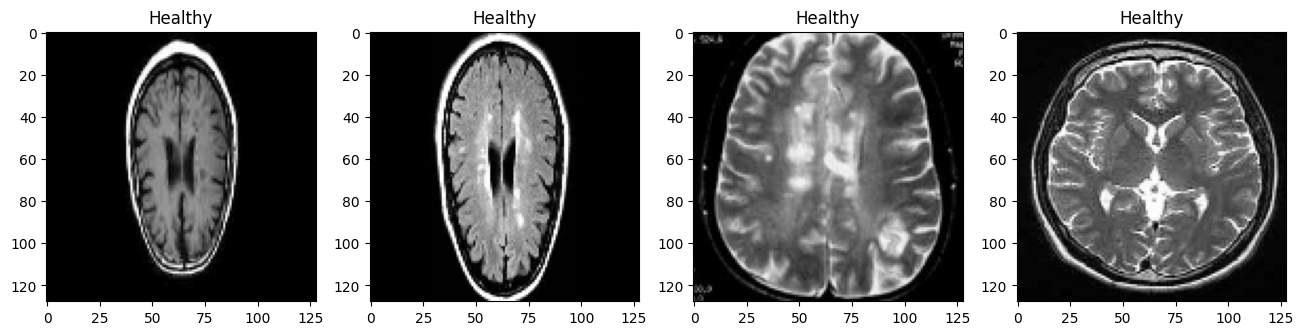

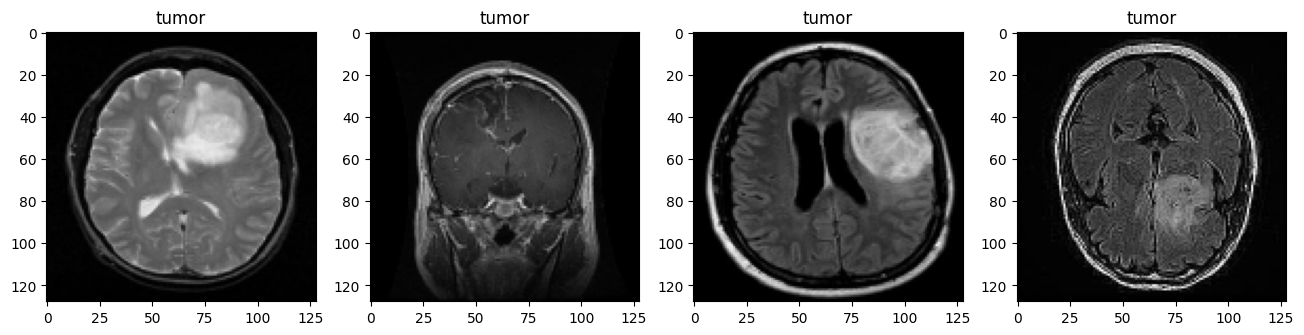

In [37]:
plot_random(4)

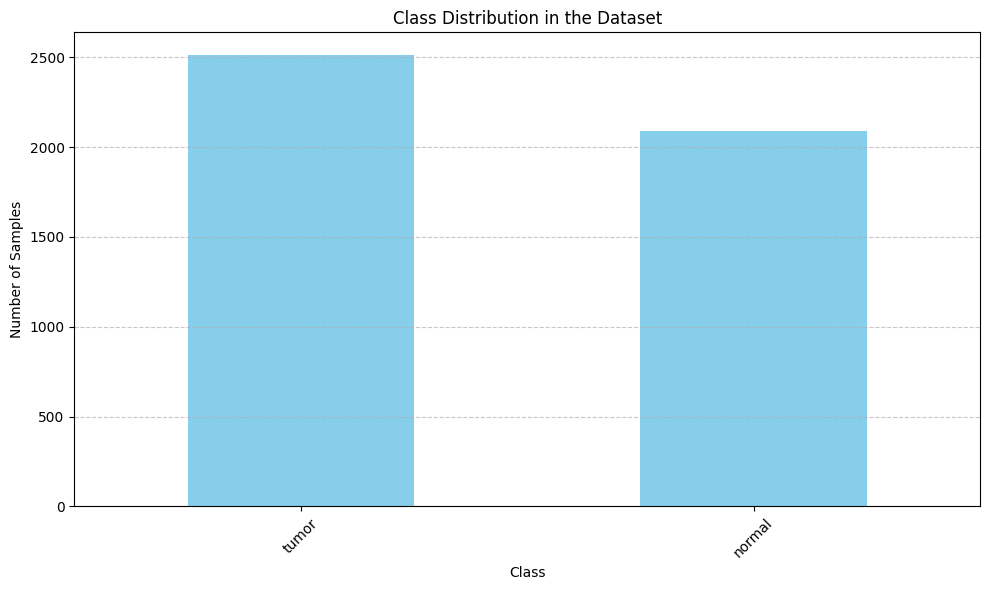

In [38]:
# Plot the distribution of the target variable
# Count the number of samples for each class
class_counts = sample_df['class'].value_counts()

# Create a bar plot for the class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)  # Rotate the labels on the x-axis for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid on the y-axis
plt.tight_layout()  # Optimize the layout of the plots to avoid overlap
plt.show()


### <b>1.3 <span style="color:#1f77b4">|</span> Splitting Dataset

In [39]:
#create a dataset class that extends the Dataset class from PyTorch
#Split the data into training and testing sets using the train_test_split function from scikit-learn

cbd = CustomBrainDataset() 

### <b>1.4 <span style="color:#1f77b4">|</span> Creating Data Loader

In [40]:

# Creazione dei DataLoader
train_dataset = CustomBrainDataset(mode='train')
val_dataset = CustomBrainDataset(mode='val')
test_dataset = CustomBrainDataset(mode='test')

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the number of samples in each set
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))


3220
828
552


## <b>2 <span style="color:#1f77b4">|</span> Define a Brain Tumor Classifier🛠️

In [41]:
# Define the model extending the nn.Module class from PyTorch
# Create an instance of the model
brain_cnn = BrainCNN()

# Gpu configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {torch.cuda.get_device_name(device)}")

# Move the model to the device
brain_cnn.to(device)
print(brain_cnn)

Using NVIDIA GeForce RTX 3060 Laptop GPU
BrainCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=32768, out_features=512, bi

In [42]:
# Model Summary for CNN Model
summary(brain_cnn, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Linear-13                  [-1, 512]      16,777,728
             ReLU-14                  [

## <b>3 <span style="color:#1f77b4">|</span> Training Model ⚙

### <b>3.1 <span style="color:#1f77b4">|</span> Loss Function Definition

In [43]:
criterion = nn.BCELoss()

### <b>3.2 <span style="color:#1f77b4">|</span> Optimiser Definition 

In [44]:
eta = 0.001

optimizer = torch.optim.Adam(brain_cnn.parameters(), lr=eta)

### <b>3.3 <span style="color:#1f77b4">|</span> Training Function

Train Epoch [10/50], Train Loss: 0.295629, Val Loss: 0.270867, Train Accuracy: 87.33%, Val Accuracy: 89.73%
Train Epoch [20/50], Train Loss: 0.172225, Val Loss: 0.191588, Train Accuracy: 93.88%, Val Accuracy: 91.79%
Train Epoch [30/50], Train Loss: 0.077022, Val Loss: 0.156639, Train Accuracy: 96.96%, Val Accuracy: 94.57%
Train Epoch [40/50], Train Loss: 0.049232, Val Loss: 0.152894, Train Accuracy: 97.95%, Val Accuracy: 94.69%
Train Epoch [50/50], Train Loss: 0.044110, Val Loss: 0.182980, Train Accuracy: 98.26%, Val Accuracy: 94.44%


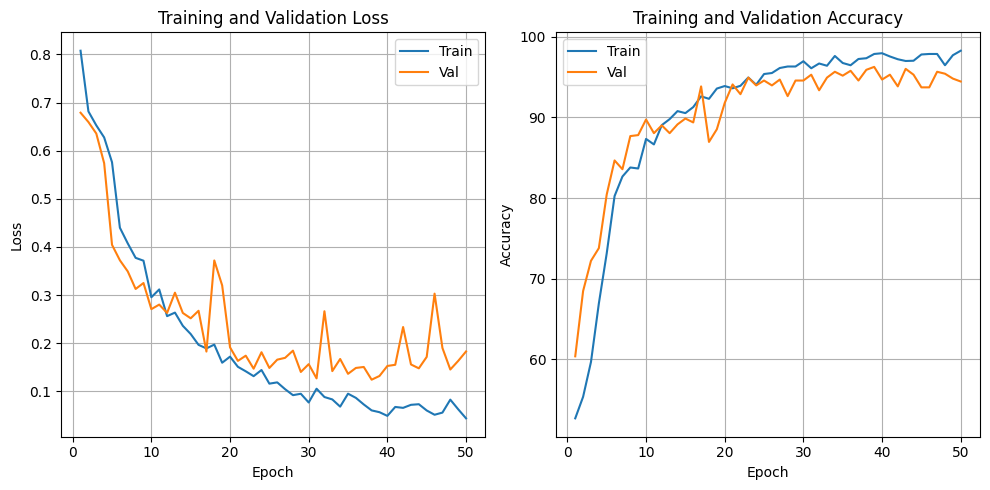

In [45]:
num_epochs = 50

train_model(brain_cnn, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, patience=5, seed=42)    


### <b>3.4 <span style="color:#1f77b4">|</span> Performance - Confusion Matrix 📈

Test Accuracy: 0.9601449275362319
Precision: 0.9602649006622517
Recall: 0.9666666666666667
F1 Score: 0.9634551495016611


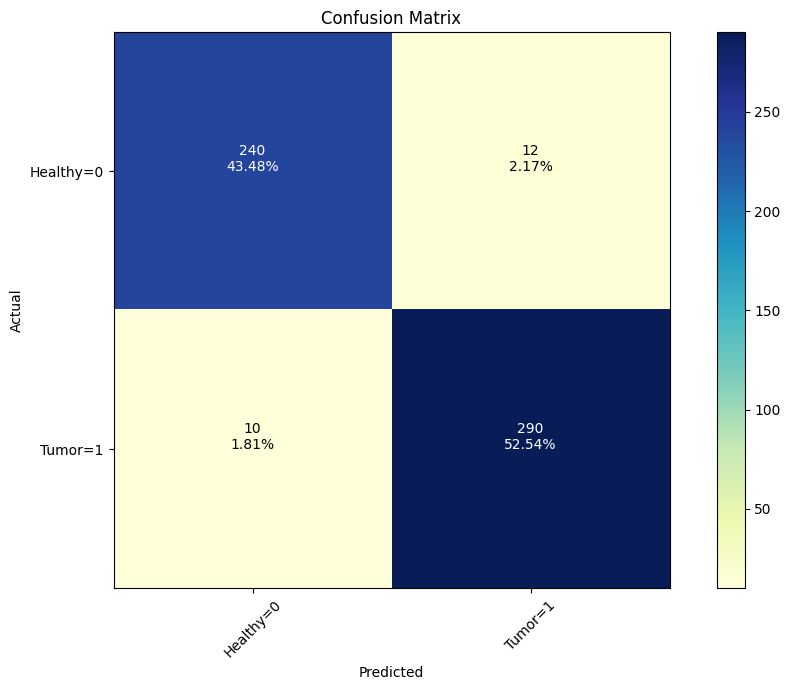

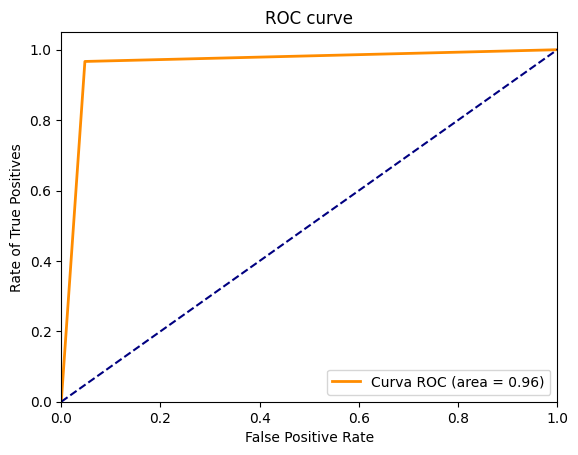

AUC: 0.96


In [46]:
# Test the model

test_model(brain_cnn, test_dataloader, seed=42)

## <b>4 <span style="color:#1f77b4">|</span> Pre-Trained ResNet Model

In [47]:
# Defined a ResNet model

class CustomResNet(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomResNet, self).__init__()
        # Load the ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Change the output layer to have 1 output
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        return self.resnet(x)

### <b>4.1 <span style="color:#1f77b4">|</span> Create an instance of the model

In [48]:
model_resnet = CustomResNet()

c:\Users\lucag\.conda\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucag\.conda\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### <b>4.2 <span style="color:#1f77b4">|</span> Loss Function Definition

In [49]:
criterion = nn.BCELoss()

### <b>4.3 <span style="color:#1f77b4">|</span> Optimiser Definition 

In [50]:
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

### <b>4.4 <span style="color:#1f77b4">|</span> Training ResNet

Train Epoch [10/50], Train Loss: 0.011669, Val Loss: 0.127331, Train Accuracy: 99.66%, Val Accuracy: 96.26%
Train Epoch [20/50], Train Loss: 0.015040, Val Loss: 0.378171, Train Accuracy: 99.47%, Val Accuracy: 93.60%
Train Epoch [30/50], Train Loss: 0.000038, Val Loss: 0.155212, Train Accuracy: 100.00%, Val Accuracy: 97.58%
Train Epoch [40/50], Train Loss: 0.000016, Val Loss: 0.154267, Train Accuracy: 100.00%, Val Accuracy: 97.58%
Train Epoch [50/50], Train Loss: 0.000013, Val Loss: 0.157472, Train Accuracy: 100.00%, Val Accuracy: 97.34%


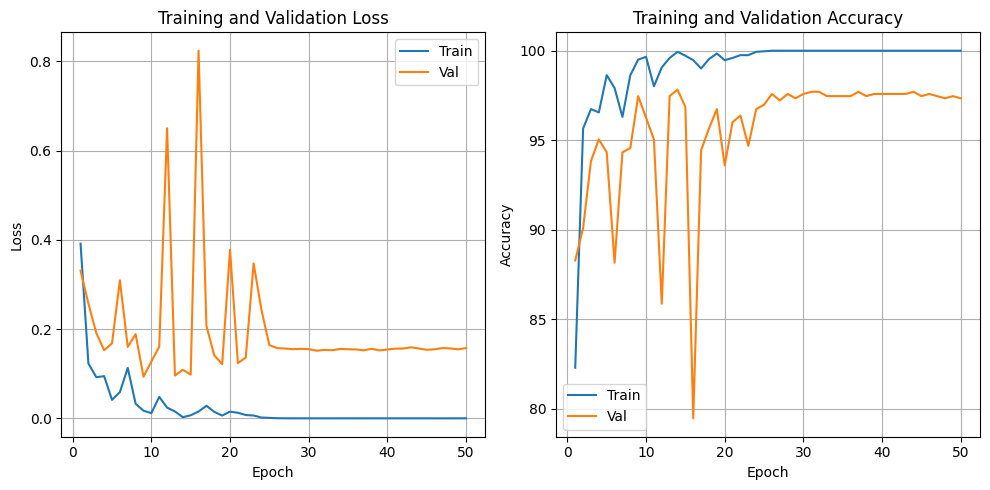

In [51]:
train_model(model_resnet, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, patience=5, seed=42)
## nervous trend can also be caused by a small batch

### <b>4.5 <span style="color:#1f77b4">|</span> ResNet - Performance - Confusion Matrix

Test Accuracy: 0.9746376811594203
Precision: 0.9703947368421053
Recall: 0.9833333333333333
F1 Score: 0.9768211920529801


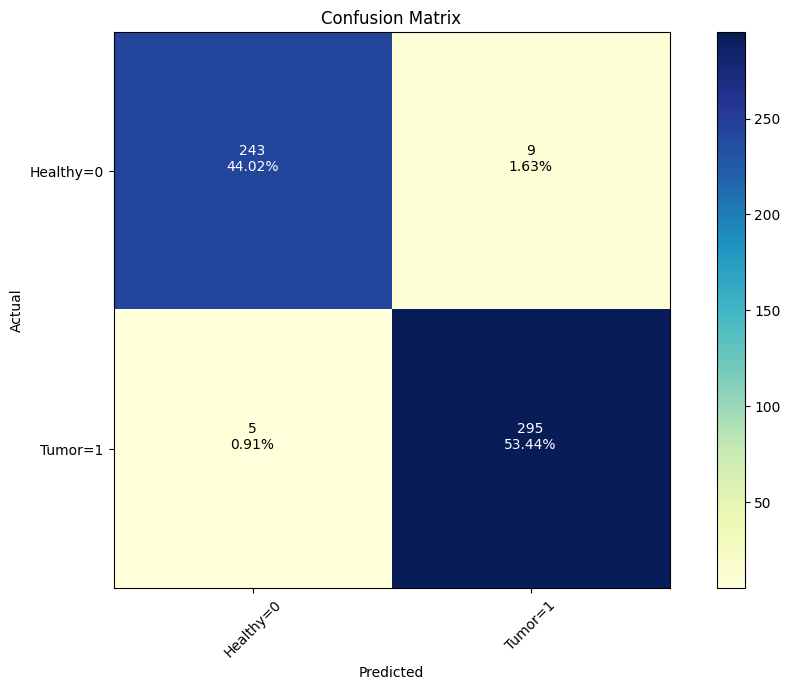

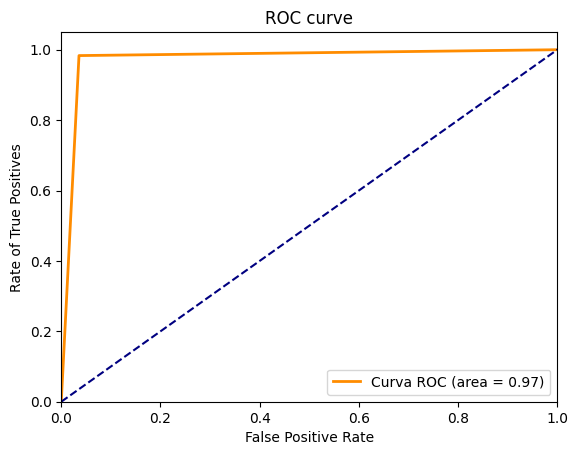

AUC: 0.97


In [52]:
test_model(model_resnet, test_dataloader, seed=42)

## <b>5 <span style="color:#1f77b4">|</span> Personalised alternative version of CNN


In [53]:
import torch.nn as nn

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = self._make_block(3, 64, num_layers=1)
        self.conv2 = self._make_block(64, 128, num_layers=1)
        self.conv3 = self._make_block(128, 256, num_layers=1)
        self.conv4 = self._make_block(256, 512, num_layers=1)

        self.flat_dim = 128
        self._calculate_conv_output(128, 2, 0, 2)
        self._calculate_conv_output(self.flat_dim, 3, 1, 1)
        self._calculate_conv_output(self.flat_dim, 2, 0, 2)
        self._calculate_conv_output(self.flat_dim, 3, 1, 1)
        self._calculate_conv_output(self.flat_dim, 2, 0, 2)
        self._calculate_conv_output(self.flat_dim, 3, 1, 1)
        self._calculate_conv_output(self.flat_dim, 2, 0, 2)

        self.fc1 = nn.Sequential(
            nn.Linear(self.flat_dim * self.flat_dim * 512, 1024),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def _calculate_conv_output(self, input_dim, kernel_dim, padding, stride):
        """
        Calcola la dimensione dell'output di un layer convoluzionale.
        """
        output_dim = ((input_dim - kernel_dim + 2 * padding) // stride) + 1
        self.flat_dim = output_dim

    def _make_block(self, in_channels, out_channels, num_layers=2):
        layers = []
        for _ in range(num_layers):
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ]
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(-1, self.flat_dim * self.flat_dim * 512)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x



### <b>5.1 <span style="color:#1f77b4">|</span> Create an instance of the model


In [54]:
# Create instantiation of Network class
improvedCNN = ImprovedCNN()

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Improved_CNN_model = improvedCNN.to(device)

In [55]:
# Model Summary for CNN Model
summary(improvedCNN, input_size=(3, 128, 128),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         295,168
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-14          [-1, 512,

### <b>5.2 <span style="color:#1f77b4">|</span> Loss Function Definition

In [56]:
criterion = nn.BCELoss()

### <b>5.3 <span style="color:#1f77b4">|</span> Optimiser Definition

In [57]:
optimizer = torch.optim.Adam(improvedCNN.parameters(), lr=0.001)

### <b>5.3 <span style="color:#1f77b4">|</span> Training Model

Train Epoch [10/50], Train Loss: 0.394099, Val Loss: 0.379666, Train Accuracy: 82.08%, Val Accuracy: 83.21%
Train Epoch [20/50], Train Loss: 0.170064, Val Loss: 0.207498, Train Accuracy: 92.86%, Val Accuracy: 91.18%
Train Epoch [30/50], Train Loss: 0.130807, Val Loss: 0.161921, Train Accuracy: 95.37%, Val Accuracy: 93.24%
Train Epoch [40/50], Train Loss: 0.065376, Val Loss: 0.131480, Train Accuracy: 97.33%, Val Accuracy: 94.81%
Train Epoch [50/50], Train Loss: 0.032400, Val Loss: 0.178878, Train Accuracy: 98.70%, Val Accuracy: 96.26%


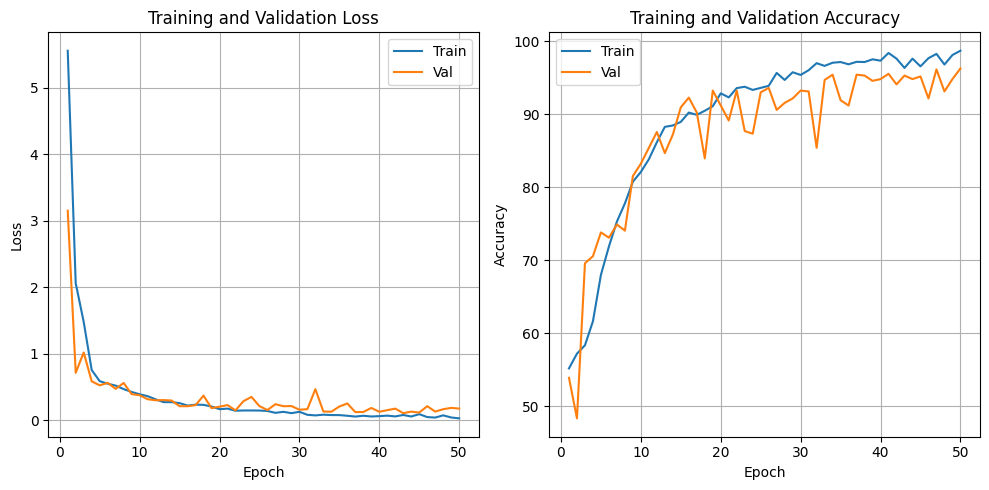

In [58]:
train_model(improvedCNN, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, patience=3, seed=42)

### <b>5.4 <span style="color:#1f77b4">|</span> Test Model

Test Accuracy: 0.9547101449275363
Precision: 0.9824561403508771
Recall: 0.9333333333333333
F1 Score: 0.9572649572649573


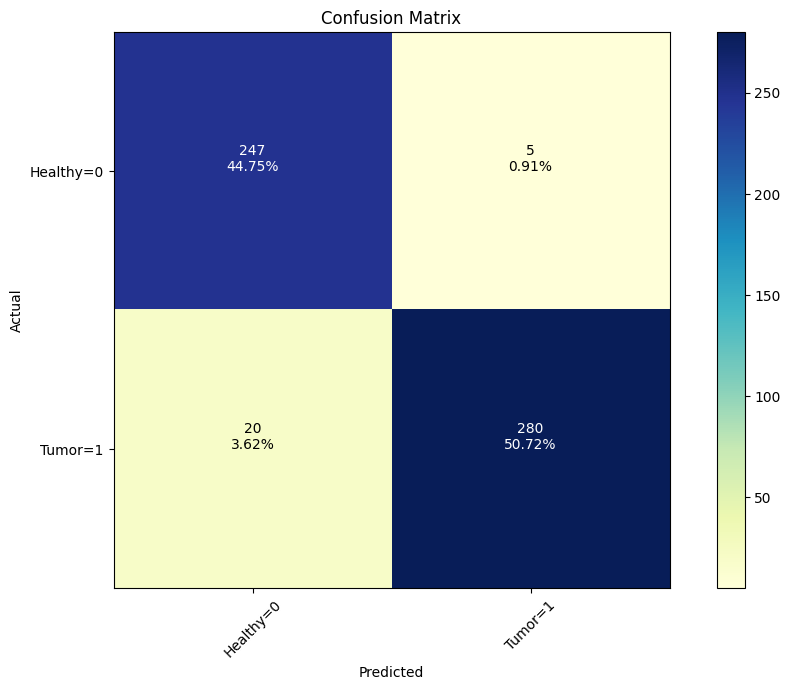

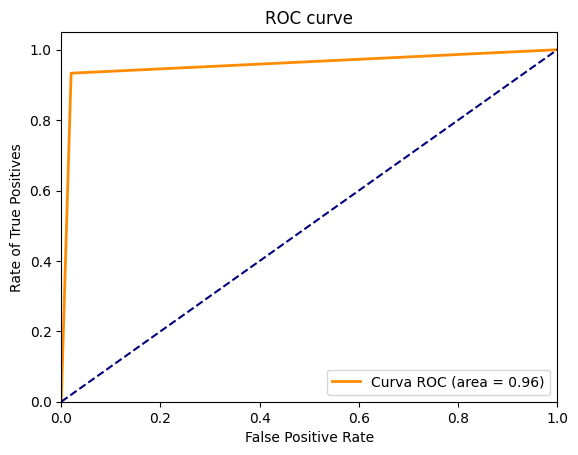

AUC: 0.96


In [59]:
test_model(improvedCNN, test_dataloader)

## <b>6 <span style="color:#1f77b4">|</span> Save Model 📚

In [60]:
# Save the model
torch.save(improvedCNN.state_dict(), 'improvedCNN.pth')
torch.save(model_resnet.state_dict(), 'model_resnet.pth')
torch.save(brain_cnn.state_dict(), 'brain_cnn.pth')
